In [ ]:
from matplotlib import pyplot as plt
from PIL import Image as im
from PIL import ImageFilter
import numpy as np
import random
import math
import os

In [ ]:
#
# Shorthand:
#   "pd_" as a variable prefix means "partial derivative"
#   "d_" as a variable prefix means "derivative"
#   "_wrt_" is shorthand for "with respect to"
#   "w_ho" and "w_ih" are the index of weights from hidden to output layer neurons and input to hidden layer neurons respectively
#
# Comment references:
#
# [1] Wikipedia article on Backpropagation
#   http://en.wikipedia.org/wiki/Backpropagation#Finding_the_derivative_of_the_error
# [2] Neural Networks for Machine Learning course on Coursera by Geoffrey Hinton
#   https://class.coursera.org/neuralnets-2012-001/lecture/39
# [3] The Back Propagation Algorithm
#   https://www4.rgu.ac.uk/files/chapter3%20-%20bp.pdf

class NeuralNetwork:

    def __init__(self, num_inputs, num_hidden, num_outputs, hidden_layer_weights = None, hidden_layer_bias = None, output_layer_weights = None, output_layer_bias = None):
        self.num_inputs = num_inputs

        self.hidden_layer = NeuronLayer(num_hidden, hidden_layer_bias)
        self.output_layer = NeuronLayer(num_outputs, output_layer_bias)

        self.init_weights_from_inputs_to_hidden_layer_neurons(hidden_layer_weights)
        self.init_weights_from_hidden_layer_neurons_to_output_layer_neurons(output_layer_weights)

    def init_weights_from_inputs_to_hidden_layer_neurons(self, hidden_layer_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_weights:
                    self.hidden_layer.neurons[h].weights.append(random.random())
                else:
                    self.hidden_layer.neurons[h].weights.append(hidden_layer_weights[weight_num])
                weight_num += 1

    def init_weights_from_hidden_layer_neurons_to_output_layer_neurons(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(random.random())
                else:
                    self.output_layer.neurons[o].weights.append(output_layer_weights[weight_num])
                weight_num += 1

    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer')
        self.hidden_layer.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')

    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs)
        return self.output_layer.feed_forward(hidden_layer_outputs)

    # Uses online learning, ie updating the weights after each training case
    def train(self, training_inputs, training_outputs):
        self.feed_forward(training_inputs)

        # 1. Output neuron deltas
        pd_errors_wrt_output_neuron_total_net_input = [0] * len(self.output_layer.neurons)
        for o in range(len(self.output_layer.neurons)):

            # ∂E/∂zⱼ
            pd_errors_wrt_output_neuron_total_net_input[o] = self.output_layer.neurons[o].calculate_pd_error_wrt_total_net_input(training_outputs[o])

        # 2. Hidden neuron deltas
        pd_errors_wrt_hidden_neuron_total_net_input = [0] * len(self.hidden_layer.neurons)
        for h in range(len(self.hidden_layer.neurons)):

            # We need to calculate the derivative of the error with respect to the output of each hidden layer neuron
            # dE/dyⱼ = Σ ∂E/∂zⱼ * ∂z/∂yⱼ = Σ ∂E/∂zⱼ * wᵢⱼ
            d_error_wrt_hidden_neuron_output = 0
            for o in range(len(self.output_layer.neurons)):
                d_error_wrt_hidden_neuron_output += pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].weights[h]

            # ∂E/∂zⱼ = dE/dyⱼ * ∂zⱼ/∂
            pd_errors_wrt_hidden_neuron_total_net_input[h] = d_error_wrt_hidden_neuron_output * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_input()

        # 3. Update output neuron weights
        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):

                # ∂Eⱼ/∂wᵢⱼ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢⱼ
                pd_error_wrt_weight = pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].calculate_pd_total_net_input_wrt_weight(w_ho)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.output_layer.neurons[o].weights[w_ho] -= LEARNING_RATE * pd_error_wrt_weight

        # 4. Update hidden neuron weights
        for h in range(len(self.hidden_layer.neurons)):
            for w_ih in range(len(self.hidden_layer.neurons[h].weights)):

                # ∂Eⱼ/∂wᵢ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢ
                pd_error_wrt_weight = pd_errors_wrt_hidden_neuron_total_net_input[h] * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_weight(w_ih)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.hidden_layer.neurons[h].weights[w_ih] -= LEARNING_RATE * pd_error_wrt_weight

    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].calculate_error(training_outputs[o])
        return total_error

class NeuronLayer:
    def __init__(self, num_neurons, bias):

        # Every neuron in a layer shares the same bias
        self.bias = bias if bias else random.random()

        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

class Neuron:
    def __init__(self, bias):
        self.bias = bias
        self.weights = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    # Apply the logistic function to squash the output of the neuron
    # The result is sometimes referred to as 'net' [2] or 'net' [1]
    def squash(self, total_net_input):
        return 1 / (1 + math.exp(-total_net_input))

    # Determine how much the neuron's total input has to change to move closer to the expected output
    #
    # Now that we have the partial derivative of the error with respect to the output (∂E/∂yⱼ) and
    # the derivative of the output with respect to the total net input (dyⱼ/dzⱼ) we can calculate
    # the partial derivative of the error with respect to the total net input.
    # This value is also known as the delta (δ) [1]
    # δ = ∂E/∂zⱼ = ∂E/∂yⱼ * dyⱼ/dzⱼ
    #
    def calculate_pd_error_wrt_total_net_input(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.calculate_pd_total_net_input_wrt_input();

    # The error for each neuron is calculated by the Mean Square Error method:
    def calculate_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    # The partial derivate of the error with respect to actual output then is calculated by:
    # = 2 * 0.5 * (target output - actual output) ^ (2 - 1) * -1
    # = -(target output - actual output)
    #
    # The Wikipedia article on backpropagation [1] simplifies to the following, but most other learning material does not [2]
    # = actual output - target output
    #
    # Alternative, you can use (target - output), but then need to add it during backpropagation [3]
    #
    # Note that the actual output of the output neuron is often written as yⱼ and target output as tⱼ so:
    # = ∂E/∂yⱼ = -(tⱼ - yⱼ)
    def calculate_pd_error_wrt_output(self, target_output):
        return -(target_output - self.output)

    # The total net input into the neuron is squashed using logistic function to calculate the neuron's output:
    # yⱼ = φ = 1 / (1 + e^(-zⱼ))
    # Note that where ⱼ represents the output of the neurons in whatever layer we're looking at and ᵢ represents the layer below it
    #
    # The derivative (not partial derivative since there is only one variable) of the output then is:
    # dyⱼ/dzⱼ = yⱼ * (1 - yⱼ)
    def calculate_pd_total_net_input_wrt_input(self):
        return self.output * (1 - self.output)

    # The total net input is the weighted sum of all the inputs to the neuron and their respective weights:
    # = zⱼ = netⱼ = x₁w₁ + x₂w₂ ...
    #
    # The partial derivative of the total net input with respective to a given weight (with everything else held constant) then is:
    # = ∂zⱼ/∂wᵢ = some constant + 1 * xᵢw₁^(1-0) + some constant ... = xᵢ
    def calculate_pd_total_net_input_wrt_weight(self, index):
        return self.inputs[index]

In [ ]:
def convolution(img, filt_size):
    km = np.random.randint(-3, 4, (filt_size, filt_size))
    k = ImageFilter.Kernel(
        size=km.shape,
        kernel=tuple(km.flatten()),
        scale=np.sum(km),
        offset=0
        )
    
    return img.filter(k)

In [ ]:
def maxPooling(img, stride):
    pixels = np.array(img)
    downSampledPixels = pixels[::stride,::stride]
    return im.fromarray(downSampledPixels, 'L')

In [ ]:
def prepro2(img, filterCount, filterSize, stride):
    
    images = []
    for i in range(len(img)):
        for j in range(filterCount):
            conv = convolution(img[i], filterSize)
            pool = maxPooling(conv, stride)
            images.append(pool)
    
    return images

In [ ]:
def flatting(images):
    imgArrays = []
    for i in range(len(images)):
        pixels = np.array(images[i])
        imgArrays.append(pixels.flatten())
    
    return imgArrays

In [ ]:
def prepro1(roundCount, img, label, filterCount, filterSize, stride):
    images = [img]
    for i in range(roundCount):
        images = prepro2(images, filterCount, filterSize, stride)
    
    imgArrays = flatting(images)
    labels = [label]*len(imgArrays)
    data = zip(imgArrays, labels)
    
    return data

In [ ]:
def getData(root):
    os.chdir(root)
    labels = os.listdir()

    data = {}
    for label in labels:
        data[label] = []
        imgNames = os.listdir(label)
        for image in imgNames:
            data[label].append(im.open(label + '/' + image).convert('L'))

    return data

In [ ]:
import time
from tqdm import tqdm

In [ ]:
classes = []
for j in range(1, 11):
    classes.append([int(i) for i in str(bin(128+11*j))[2:]][1:])

classes

In [ ]:
def prepro(data, roundCount, filterCount, filterSize, stride):
    preprocessedData = []
    i = 0
    for label in data.keys():
        print('* '*i)
        for j in tqdm(range(len(data[label]))):
            imgArs = prepro1(roundCount=roundCount, img=data[label][j], label=classes[i], filterCount=filterCount, filterSize=filterSize, stride=stride)
            preprocessedData += list(imgArs)
        i += 1
            
    return preprocessedData

In [ ]:
data = getData('train')

In [ ]:
roundCount=3
filterCount=5
filterSize=3
stride=2

preprocessedData = prepro(data, roundCount, filterCount, filterSize, stride)

In [ ]:
training_sets = list(preprocessedData)

In [ ]:
training_sets[0]

In [ ]:
errorList = []

In [ ]:
nn = NeuralNetwork(len(training_sets[0][0]), len(training_sets[0][0]), len(training_sets[0][1]))


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

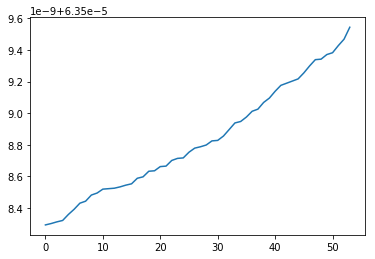


  0%|                                                                               | 1/1000 [00:06<1:46:48,  6.41s/it]

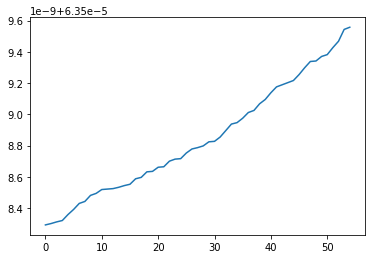


  0%|▏                                                                              | 2/1000 [00:13<1:47:45,  6.48s/it]

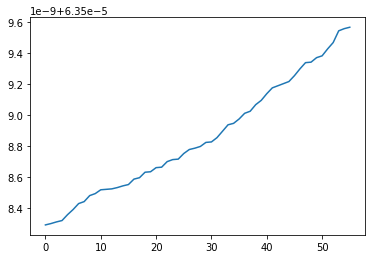


  0%|▏                                                                              | 3/1000 [00:19<1:49:45,  6.60s/it]

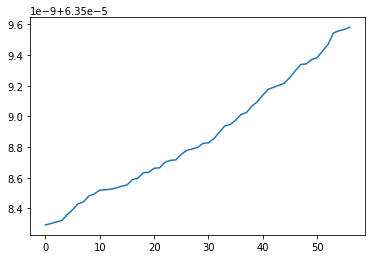


  0%|▎                                                                              | 4/1000 [00:26<1:49:25,  6.59s/it]

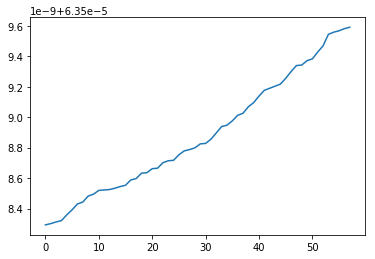


  0%|▍                                                                              | 5/1000 [00:33<1:50:27,  6.66s/it]

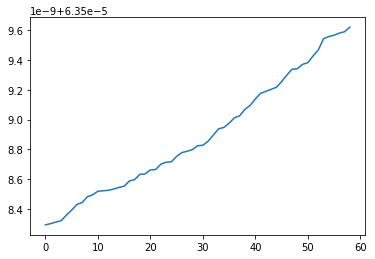


  1%|▍                                                                              | 6/1000 [00:40<1:51:16,  6.72s/it]

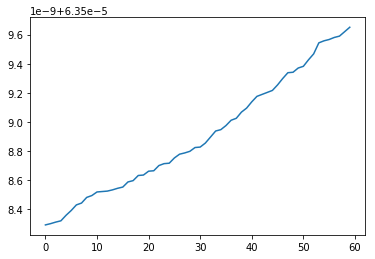


  1%|▌                                                                              | 7/1000 [00:46<1:50:25,  6.67s/it]

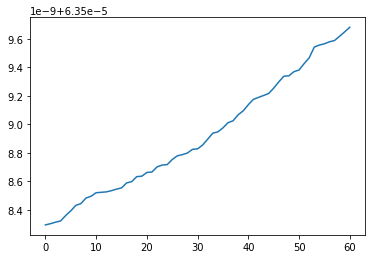


  1%|▋                                                                              | 8/1000 [00:53<1:52:00,  6.77s/it]

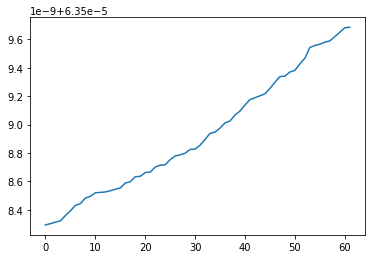


  1%|▋                                                                              | 9/1000 [01:00<1:51:22,  6.74s/it]

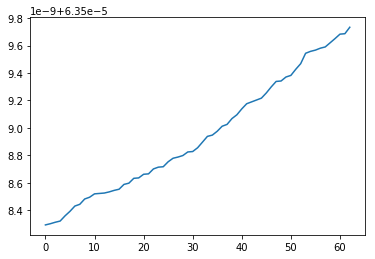


  1%|▊                                                                             | 10/1000 [01:07<1:51:06,  6.73s/it]

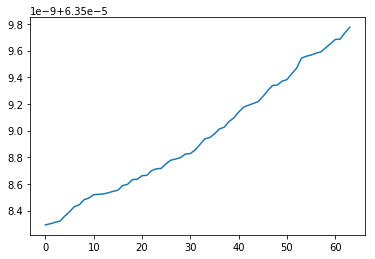


  1%|▊                                                                             | 11/1000 [01:13<1:50:09,  6.68s/it]

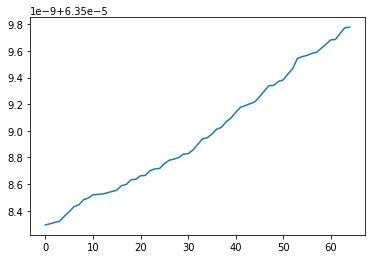


  1%|▉                                                                             | 12/1000 [01:20<1:49:34,  6.65s/it]

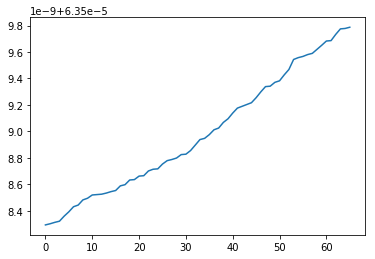


  1%|█                                                                             | 13/1000 [01:26<1:48:49,  6.62s/it]

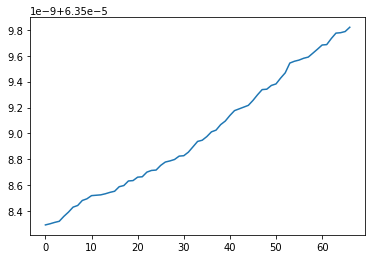


  1%|█                                                                             | 14/1000 [01:33<1:49:26,  6.66s/it]

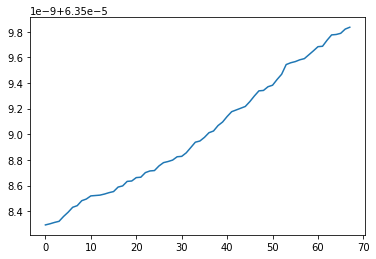


  2%|█▏                                                                            | 15/1000 [01:40<1:49:39,  6.68s/it]

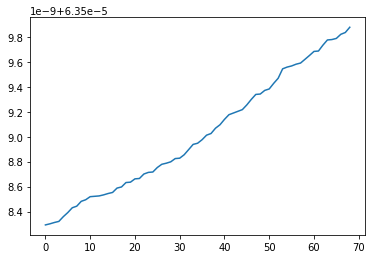


  2%|█▏                                                                            | 16/1000 [01:47<1:51:10,  6.78s/it]

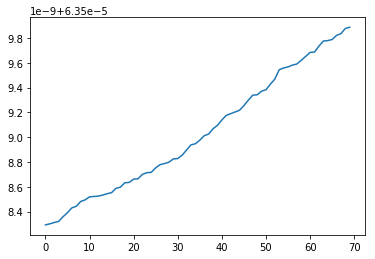


  2%|█▎                                                                            | 17/1000 [01:53<1:49:51,  6.71s/it]

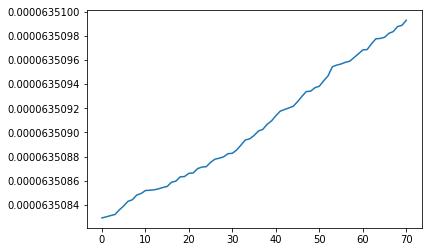


  2%|█▍                                                                            | 18/1000 [02:00<1:50:10,  6.73s/it]

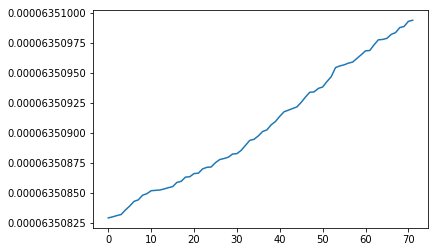


  2%|█▍                                                                            | 19/1000 [02:07<1:48:52,  6.66s/it]

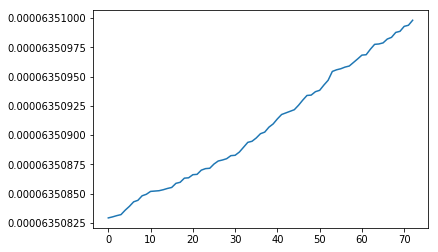


  2%|█▌                                                                            | 20/1000 [02:13<1:47:51,  6.60s/it]

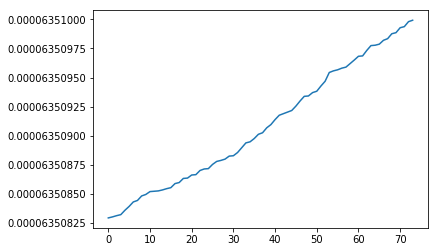


  2%|█▋                                                                            | 21/1000 [02:20<1:47:01,  6.56s/it]

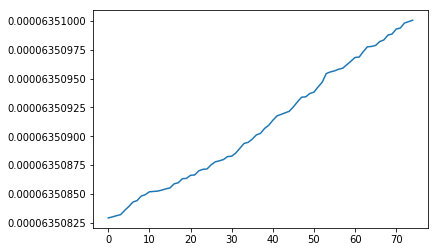


  2%|█▋                                                                            | 22/1000 [02:26<1:47:01,  6.57s/it]

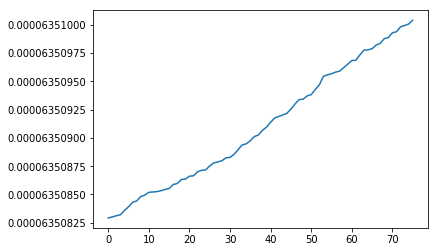


  2%|█▊                                                                            | 23/1000 [02:33<1:46:39,  6.55s/it]

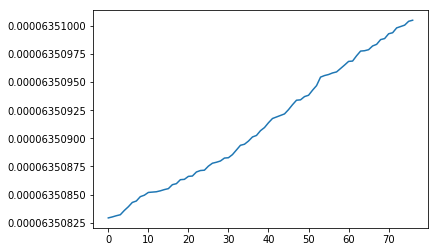


  2%|█▊                                                                            | 24/1000 [02:39<1:46:52,  6.57s/it]

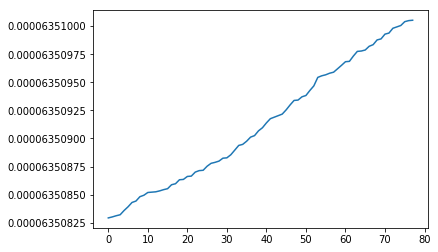


  2%|█▉                                                                            | 25/1000 [02:46<1:47:56,  6.64s/it]

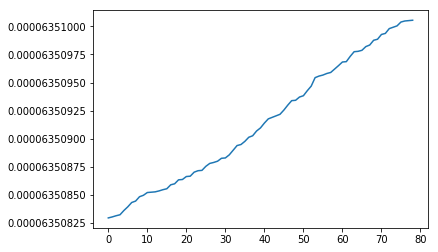


  3%|██                                                                            | 26/1000 [02:53<1:47:24,  6.62s/it]

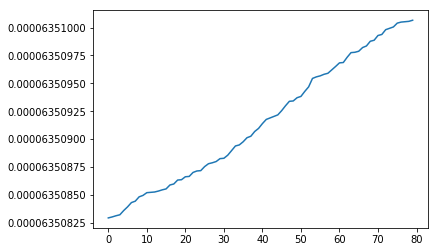


  3%|██                                                                            | 27/1000 [02:59<1:47:05,  6.60s/it]

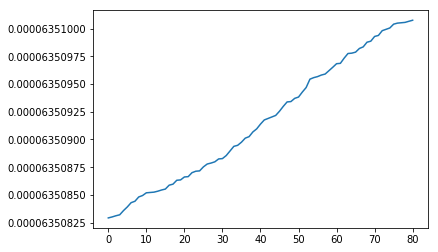


  3%|██▏                                                                           | 28/1000 [03:06<1:46:49,  6.59s/it]

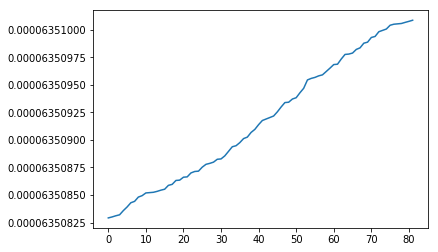


  3%|██▎                                                                           | 29/1000 [03:12<1:46:53,  6.60s/it]

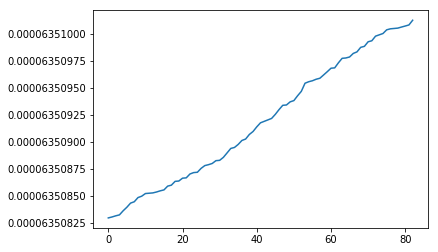


  3%|██▎                                                                           | 30/1000 [03:19<1:47:52,  6.67s/it]

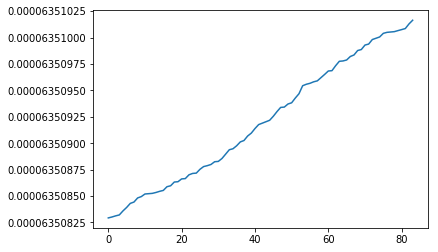


  3%|██▍                                                                           | 31/1000 [03:26<1:47:27,  6.65s/it]

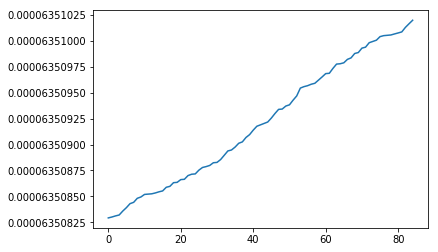


  3%|██▍                                                                           | 32/1000 [03:33<1:48:29,  6.72s/it]

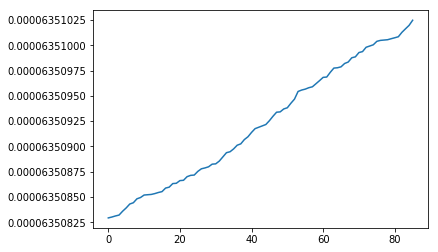


  3%|██▌                                                                           | 33/1000 [03:40<1:48:52,  6.76s/it]

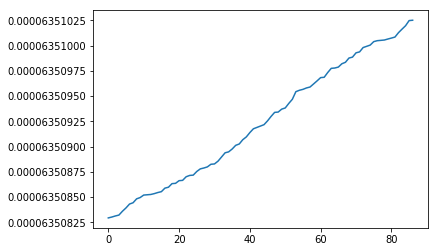


  3%|██▋                                                                           | 34/1000 [03:46<1:46:35,  6.62s/it]

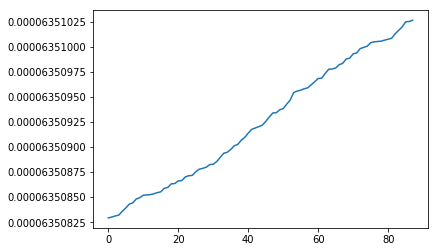


  4%|██▋                                                                           | 35/1000 [03:53<1:46:35,  6.63s/it]

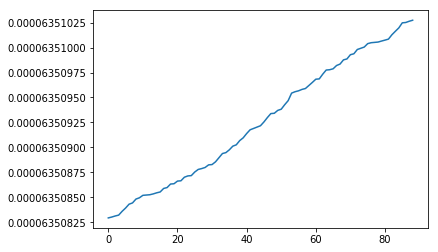


  4%|██▊                                                                           | 36/1000 [03:59<1:47:03,  6.66s/it]

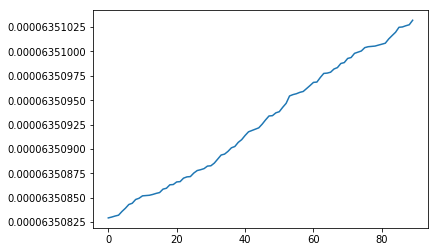


  4%|██▉                                                                           | 37/1000 [04:06<1:47:12,  6.68s/it]

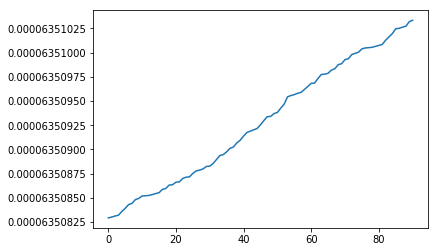


  4%|██▉                                                                           | 38/1000 [04:13<1:46:59,  6.67s/it]

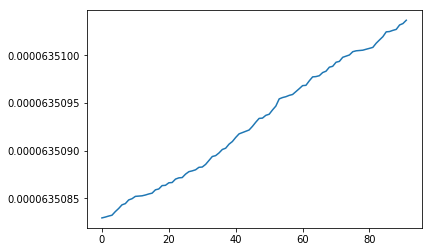


  4%|███                                                                           | 39/1000 [04:19<1:46:03,  6.62s/it]

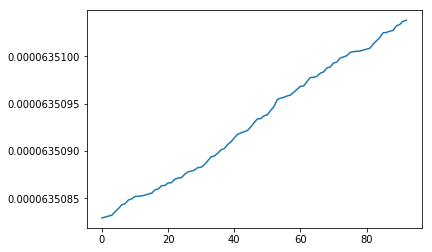


  4%|███                                                                           | 40/1000 [04:26<1:45:54,  6.62s/it]

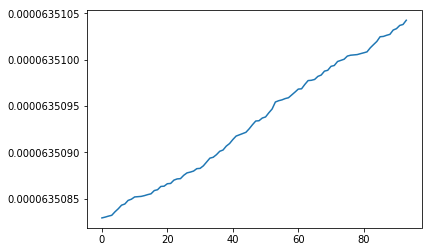


  4%|███▏                                                                          | 41/1000 [04:32<1:45:42,  6.61s/it]

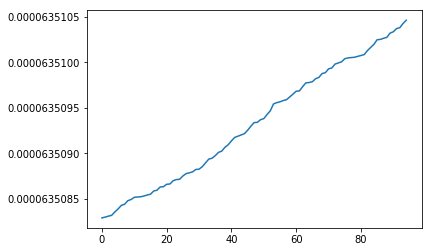


  4%|███▎                                                                          | 42/1000 [04:39<1:45:44,  6.62s/it]

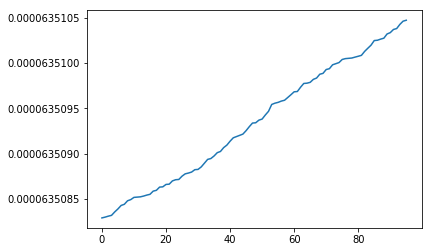


  4%|███▎                                                                          | 43/1000 [04:46<1:46:17,  6.66s/it]

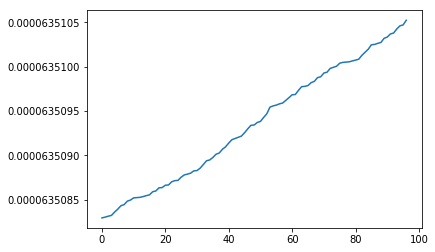


  4%|███▍                                                                          | 44/1000 [04:52<1:46:03,  6.66s/it]

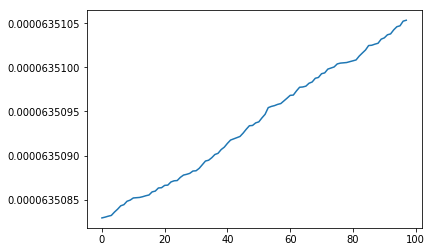


  4%|███▌                                                                          | 45/1000 [04:59<1:45:32,  6.63s/it]

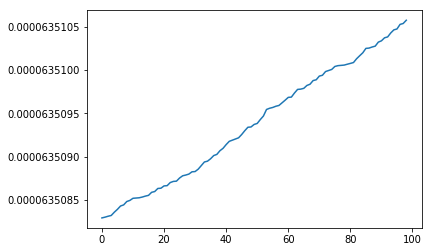


  5%|███▌                                                                          | 46/1000 [05:06<1:46:04,  6.67s/it]

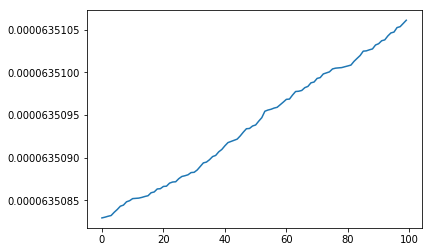


  5%|███▋                                                                          | 47/1000 [05:12<1:45:48,  6.66s/it]

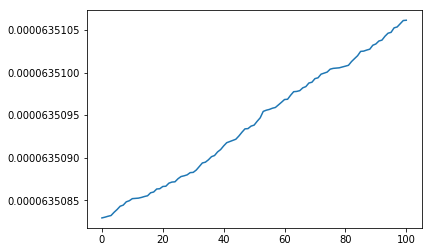


  5%|███▋                                                                          | 48/1000 [05:19<1:45:02,  6.62s/it]

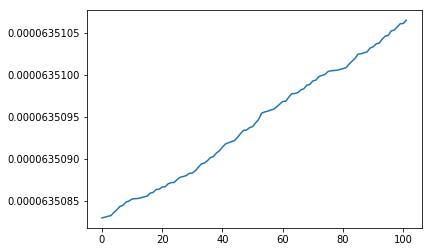


  5%|███▊                                                                          | 49/1000 [05:26<1:44:53,  6.62s/it]

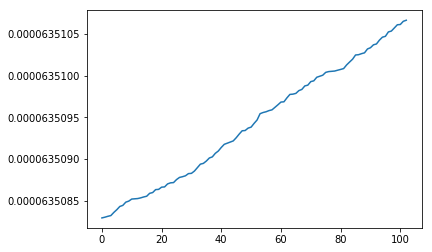


  5%|███▉                                                                          | 50/1000 [05:32<1:45:10,  6.64s/it]

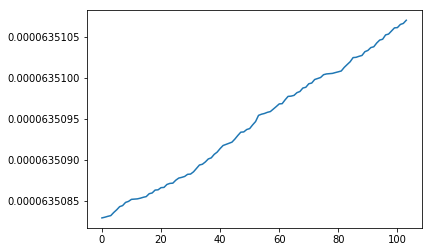


  5%|███▉                                                                          | 51/1000 [05:39<1:44:05,  6.58s/it]

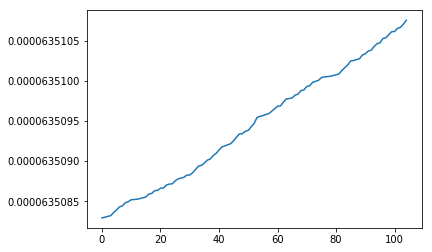


  5%|████                                                                          | 52/1000 [05:45<1:44:05,  6.59s/it]

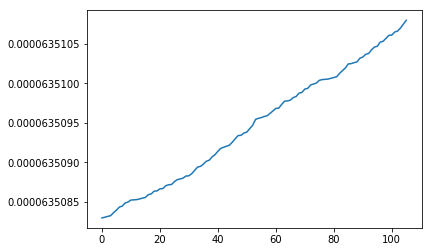


  5%|████▏                                                                         | 53/1000 [05:52<1:43:47,  6.58s/it]

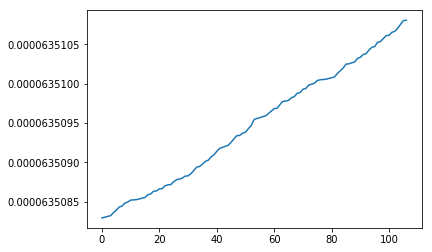


  5%|████▏                                                                         | 54/1000 [05:58<1:43:40,  6.58s/it]

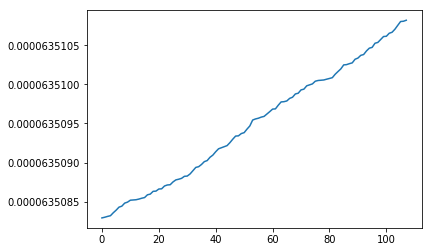


  6%|████▎                                                                         | 55/1000 [06:06<1:46:23,  6.75s/it]

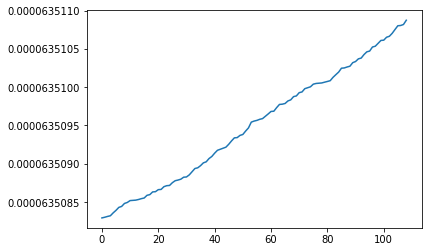


  6%|████▎                                                                         | 56/1000 [06:12<1:45:32,  6.71s/it]

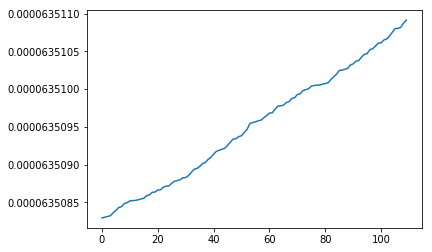


  6%|████▍                                                                         | 57/1000 [06:19<1:47:47,  6.86s/it]

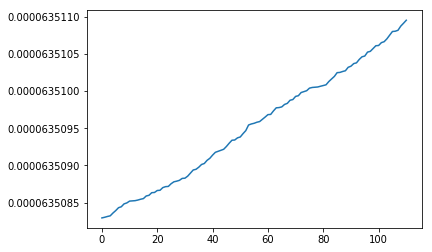


  6%|████▌                                                                         | 58/1000 [06:28<1:56:08,  7.40s/it]

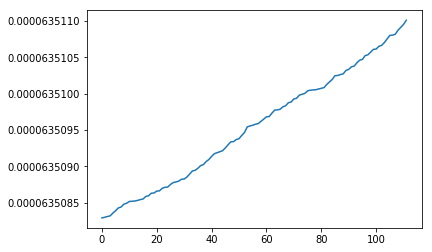


  6%|████▌                                                                         | 59/1000 [06:35<1:53:07,  7.21s/it]

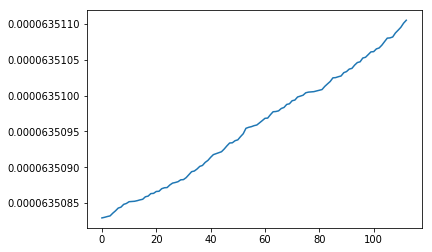


  6%|████▋                                                                         | 60/1000 [06:41<1:49:57,  7.02s/it]

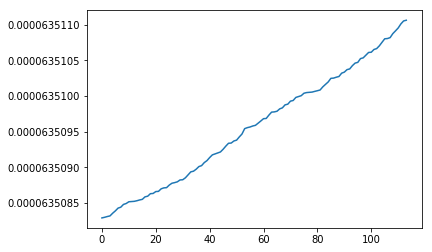


  6%|████▊                                                                         | 61/1000 [06:48<1:47:48,  6.89s/it]

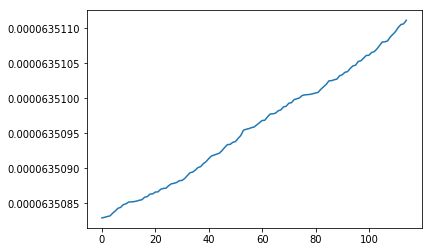


  6%|████▊                                                                         | 62/1000 [06:55<1:46:56,  6.84s/it]

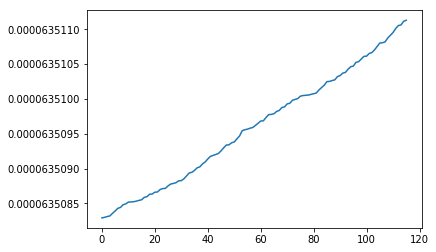


  6%|████▉                                                                         | 63/1000 [07:01<1:45:27,  6.75s/it]

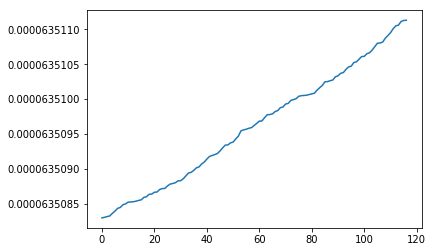


  6%|████▉                                                                         | 64/1000 [07:08<1:45:21,  6.75s/it]

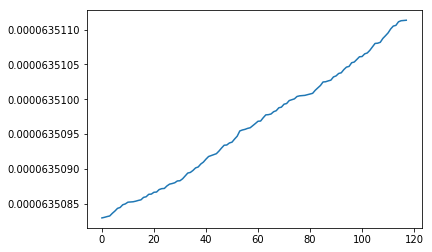


  6%|█████                                                                         | 65/1000 [07:15<1:47:12,  6.88s/it]

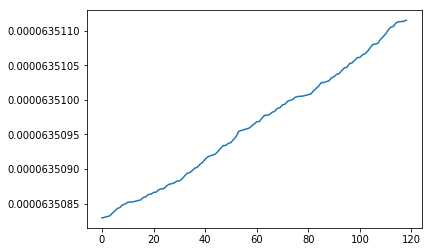


  7%|█████▏                                                                        | 66/1000 [07:22<1:47:20,  6.90s/it]

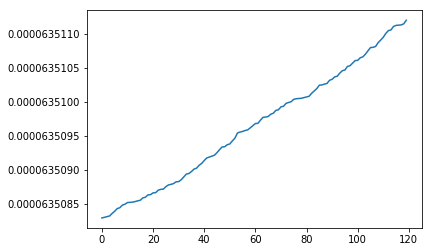


  7%|█████▏                                                                        | 67/1000 [07:29<1:47:24,  6.91s/it]

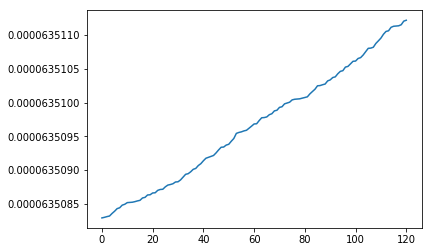


  7%|█████▎                                                                        | 68/1000 [07:36<1:47:16,  6.91s/it]

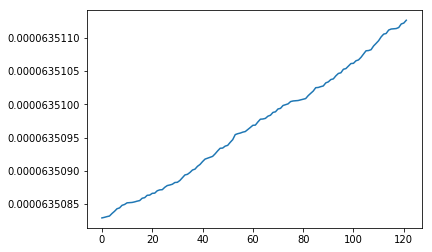


  7%|█████▍                                                                        | 69/1000 [07:43<1:46:32,  6.87s/it]

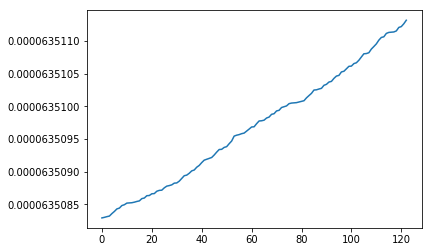


  7%|█████▍                                                                        | 70/1000 [07:49<1:45:32,  6.81s/it]

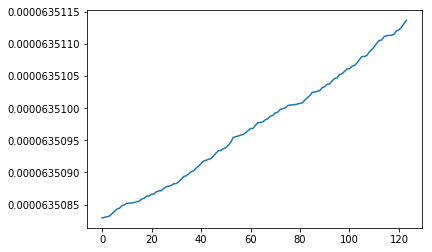


  7%|█████▌                                                                        | 71/1000 [07:56<1:44:58,  6.78s/it]

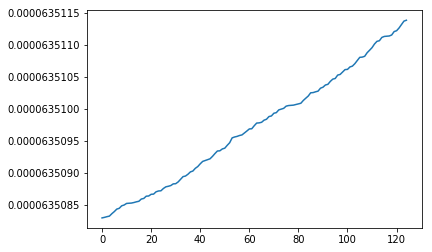


  7%|█████▌                                                                        | 72/1000 [08:03<1:44:25,  6.75s/it]

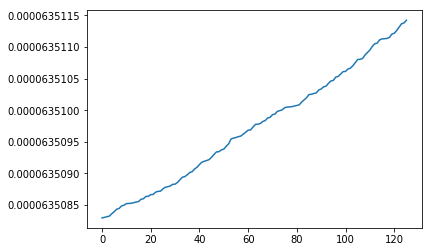


  7%|█████▋                                                                        | 73/1000 [08:09<1:43:55,  6.73s/it]

KeyboardInterrupt: 

In [81]:
LEARNING_RATE = 0.75
for i in tqdm(range(1000)):
    training_inputs, training_outputs = random.choice(training_sets)
    nn.train(training_inputs, training_outputs)
    errorList.append(1/nn.calculate_total_error(training_sets))
    plt.plot(errorList)
    plt.show()

In [ ]:
os.chdir('..')
testData = getData('test')

In [ ]:
def most_frequent(List):
    return max(set(List), key = List.count) 

In [ ]:
def predict(test_sets):
    allPredicts = []
    for test in test_sets:
        predict = np.array(nn.feed_forward(test[0]))
        for j in range(len(classes)):
            if(np.array_equal(predict, classes[j])):
                allPredicts.append(j)
    
    allPredicts.append(100)
    return most_frequent(allPredicts)

In [ ]:
predicted = []
i = 0
for label in testData:
    for img in testData[label]:
        imgArs = prepro1(roundCount=roundCount, img=img, label=classes[i], filterCount=filterCount, filterSize=filterSize, stride=stride)
        test_sets = list(imgArs)
        predictedLabel = predict(test_sets)
        predicted.append(predictedLabel == i)
    i += 1

In [ ]:
print('Performans: ', 100*predicted.count(True)/len(predicted), '%')